В этой версии добавлена аугментация, а также используется датасет, который собирался вручную (содержит ~1000 картинок каждого класса).  

star_wars: https://drive.google.com/file/d/1SrQiEci3L6X84ywf92UK0OQzp7Khgn4U/view?usp=sharing

In [0]:
import numpy as np
import torch
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
from PIL import Image

In [0]:
from google.colab import drive 
from zipfile import ZipFile

drive.mount('/content/gdrive', force_remount=True)
!cp -r /content/gdrive/'My Drive'/star_wars.zip .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with ZipFile("star_wars.zip", 'r') as zipfile:
  zipfile.extractall()
  print('Done')

Done


In [0]:
filenames = []
labels = []
dataset = []
for idx, class_dir in enumerate(os.listdir("star_wars")):
  print(f"берем файлы из папки \"{class_dir}\" и даем им класс {idx}")
  
  # не берем файлы кроме .jpg .jpeg и .png
  for file in os.listdir(os.path.join("star_wars", class_dir)):
    if not file.endswith(('.jpg', '.jpeg', '.png')):
      continue
    img = cv2.imread(os.path.join("star_wars", class_dir, file))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dataset.append(img)
    labels.append(idx)
#print(dataset[0].shape)

берем файлы из папки "chewbacca" и даем им класс 0
берем файлы из папки "darth_vader" и даем им класс 1
берем файлы из папки "luke_skywalker" и даем им класс 2
берем файлы из папки "princess_leia" и даем им класс 3


In [0]:
train_x, test_x, train_y, test_y = train_test_split(dataset, labels, test_size=0.3)
print(len(train_x))

3103


In [0]:
aug_train_x = []
aug_train_y = []
for x, y in zip(train_x, train_y):
  key = False
  new_img = x
  if random.random() < 0.08:
    new_img = new_img[:, ::-1]
    key=True
  if random.random() < 0.04:
    new_img = np.array(new_img, dtype=np.uint8)
    gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    img2 = np.zeros_like(new_img)
    img2[:,:,0] = gray
    img2[:,:,1] = gray
    img2[:,:,2] = gray
    new_img = img2
    key=True
  if random.random() < 0.08:
    new_img = sk.transform.rotate(new_img, random.uniform(-15, 15))
    key=True
  if random.random() < 0:
    new_img = sk.util.random_noise(new_img)
    key=True
  if(key):
    aug_train_x.append(new_img)
    aug_train_y.append(y)

train_x.extend(aug_train_x)
train_y.extend(aug_train_y)
print(len(train_x), len(train_y))

3683 3683


3


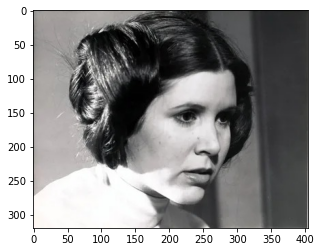

In [0]:
random_index = np.random.choice(range(len(train_x)))
print(train_y[random_index])
plt.imshow(train_x[random_index][:, :, ::-1])

In [0]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img

    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img

In [0]:
# Задание 2. Реализуйте класс-наследник Dataset. Он должен возвращать по индексу 
class StarWarsDataset(Dataset):
    def __init__(self, filenames, labels):
      self._filenames = filenames
      self._labels = labels        

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        # dataloader запросит какой-то индекс (но не больше чем значение __len__)
        # мы должны отдать ему image в виде массива и соотвуствующий ему label
        filename = self._filenames[idx]
        label = self._labels[idx]

        # мы получили имя файла, теперь нужно загрузить картинку как numpy array 
        # и изменить размер так, чтобы он был 224 на 224
        img = filename

        shape = (224, 224)
        img = resize(img, shape)
        img = add_pad(img, shape)
        
        # меняем порядок каналов и делим все на 255, оборачиваем в torch tensor
        # это просто надо делать, потом спросите зачем
  
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.0

        return img, label

In [0]:
train_dataset = StarWarsDataset(train_x, train_y)
train_dataloder = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)
test_dataset = StarWarsDataset(test_x, test_y)
test_dataloder = DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=0)

In [0]:
import matplotlib.pyplot as plt

i = 0
for batch in train_dataloder: # получаем 1 batch - 1 итерация подгрузки данных
  batch_images, batch_labels = batch     # наш Dataset возвращает tuple, поэтому мы можем сделать так
  print(f'Всего батчей по batch_size: {len(train_dataloder)}')
  print(f'Лейбл первого элемента в первом батче: {batch_labels[i]}')
  print(f'Размер картинки в первом батче: {batch_images[i].shape}')
  print(f'Картинка в первом батче: {batch_images[i]}')
  plt.imshow(batch_images[i].numpy()[0])
  plt.show()
  break

In [0]:
model = resnet34(pretrained=True) # resnet обученный на ImageNet
for param in model.parameters():
  param.requires_grad=False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.to('cuda')

# loss и optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [0]:
def run_test_on_epoch(model, epoch, test_loader):
    model.eval()
    with torch.no_grad():
      test_accuracy = []
      test_real = []

      for batch_x, batch_y in test_loader:
        outputs = model(batch_x.to('cuda')).detach().cpu().numpy()
        test_accuracy.append(outputs)
        test_real.append(batch_y.detach().cpu().numpy())
      print("Epoch", epoch, "test accuracy", accuracy_score(np.hstack(test_real), np.argmax(np.concatenate(test_accuracy), axis=1)))
    model.train()

In [0]:
for epoch in tqdm(range(25)):
  for inputs, labels in train_dataloder:
    inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  run_test_on_epoch(model, epoch, test_dataloder)

  4%|▍         | 1/25 [00:07<03:08,  7.86s/it]

Epoch 0 test accuracy 0.8715251690458302


  8%|▊         | 2/25 [00:15<03:00,  7.83s/it]

Epoch 1 test accuracy 0.9083395942900075


 12%|█▏        | 3/25 [00:23<02:51,  7.80s/it]

Epoch 2 test accuracy 0.9248685199098422


 16%|█▌        | 4/25 [00:31<02:43,  7.78s/it]

Epoch 3 test accuracy 0.9368895567242674


 20%|██        | 5/25 [00:38<02:35,  7.77s/it]

Epoch 4 test accuracy 0.9383921863260706


 24%|██▍       | 6/25 [00:46<02:27,  7.77s/it]

Epoch 5 test accuracy 0.9436513899323816


 28%|██▊       | 7/25 [00:54<02:19,  7.76s/it]

Epoch 6 test accuracy 0.9436513899323816


 32%|███▏      | 8/25 [01:02<02:12,  7.77s/it]

Epoch 7 test accuracy 0.9451540195341849


 36%|███▌      | 9/25 [01:09<02:04,  7.76s/it]

Epoch 8 test accuracy 0.9519158527422991


 40%|████      | 10/25 [01:17<01:56,  7.76s/it]

Epoch 9 test accuracy 0.9489105935386927


 44%|████▍     | 11/25 [01:25<01:48,  7.78s/it]

Epoch 10 test accuracy 0.9504132231404959
Epoch 11 test accuracy 0.9481592787377912


 52%|█████▏    | 13/25 [01:41<01:33,  7.77s/it]

Epoch 12 test accuracy 0.9511645379413974


 56%|█████▌    | 14/25 [01:48<01:25,  7.76s/it]

Epoch 13 test accuracy 0.9519158527422991


 60%|██████    | 15/25 [01:56<01:17,  7.76s/it]

Epoch 14 test accuracy 0.9564237415477085


 64%|██████▍   | 16/25 [02:04<01:09,  7.76s/it]

Epoch 15 test accuracy 0.9564237415477085


 68%|██████▊   | 17/25 [02:11<01:01,  7.74s/it]

Epoch 16 test accuracy 0.9564237415477085


 72%|███████▏  | 18/25 [02:19<00:54,  7.75s/it]

Epoch 17 test accuracy 0.9586776859504132


 76%|███████▌  | 19/25 [02:27<00:46,  7.79s/it]

Epoch 18 test accuracy 0.9594290007513148


 80%|████████  | 20/25 [02:35<00:38,  7.78s/it]

Epoch 19 test accuracy 0.9609316303531179


 84%|████████▍ | 21/25 [02:43<00:31,  7.79s/it]

Epoch 20 test accuracy 0.9601803155522164


 88%|████████▊ | 22/25 [02:50<00:23,  7.78s/it]

Epoch 21 test accuracy 0.9579263711495116


 92%|█████████▏| 23/25 [02:58<00:15,  7.78s/it]

Epoch 22 test accuracy 0.9609316303531179


 96%|█████████▌| 24/25 [03:06<00:07,  7.78s/it]

Epoch 23 test accuracy 0.9609316303531179


100%|██████████| 25/25 [03:14<00:00,  7.77s/it]

Epoch 24 test accuracy 0.9616829451540195
